# Comparing predictions from Random Forest and Mahalanobis distance-based classifiers  
In this script, I generated figures and statistics to compare the outputs of these two classification methods, as produced in `Random_Forest_testing.ipynb` and `Mahalanobis_testing.ipynb`.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(7, 4))
sc.settings.verbosity = 3

-----
anndata     0.10.8
scanpy      1.10.1
-----
PIL                         10.2.0
anyio                       NA
arrow                       1.3.0
asciitree                   NA
asttokens                   NA
astunparse                  1.6.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.11.0
bottleneck                  1.3.7
brotli                      1.0.9
certifi                     2024.08.30
cffi                        1.16.0
charset_normalizer          2.0.4
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.2.1
cycler                      0.10.0
cython_runtime              NA
dask                        2024.7.0
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
executing                   0.8.3
fastjsonschema              NA
fqdn                        NA
h5py                        3.9.0
id

#### I imported the necessary data, including the SL040 AnnData object (generated in `umap_tumor_clustering_sample_SL040.ipynb`) and the predictions from both methods.

In [3]:
test = sc.read_h5ad('/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/SL040_refined_with_umap.h5ad')
test = test[test.obs.ManualAnnotation == 'Tumor']

In [4]:
rf = pd.read_csv('/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/random_forest_predictions.csv', index_col = 0)

In [5]:
md = pd.read_csv('/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/mahalanobis_predictions.csv', index_col = 0)

In [6]:
rf  = rf[['predictions_RF', 'Sample']]
md  = md[['predictions_MD']]

In [7]:
rf_md = rf.join(md, how='left')

In [8]:
rf_md

,predictions_RF,Sample,predictions_MD
10X399_1:AAAGAACCAATGCTCA,Astrocytes,SL040B,Astrocytes
10X399_1:ATAGACCTCAGCGCGT,Astrocytes,SL040B,Astrocytes
10X399_1:ATTCTTGCAAGTTCGT,Astrocytes,SL040B,Astrocytes
10X399_1:CCTAACCTCTTCCTAA,Astrocytes,SL040B,Astrocytes
10X399_1:CTATCCGAGTCGAATA,OPCs,SL040B,Astrocytes
...,...,...,...
10X455_2:TTTGTGTTCCGTCCAT,OPCs,SL077_ATAC,OPCs
10X455_2:TTTGTGTTCGTGCTAG,pre-Astrocytes,SL077_ATAC,pre-Astrocytes
10X455_2:TTTGTTGGTAACAGGG,pre-OPCs,SL077_ATAC,OPCs
10X455_2:TTTGTTGGTGGGTGAA,OPCs,SL077_ATAC,OPCs


## General results  
In this section, I performed computations on the predictions for the entire dataset.

#### Percentage of matching predictions

In [9]:
rf_md['Match'] = rf_md['predictions_MD'] == rf_md['predictions_RF']
print("Proportion of equal predictions:", rf_md['Match'].mean())

Proportion of equal predictions: 0.6359697554136065


#### Visual representation of matching predictions between the two classification results (not included in the report).

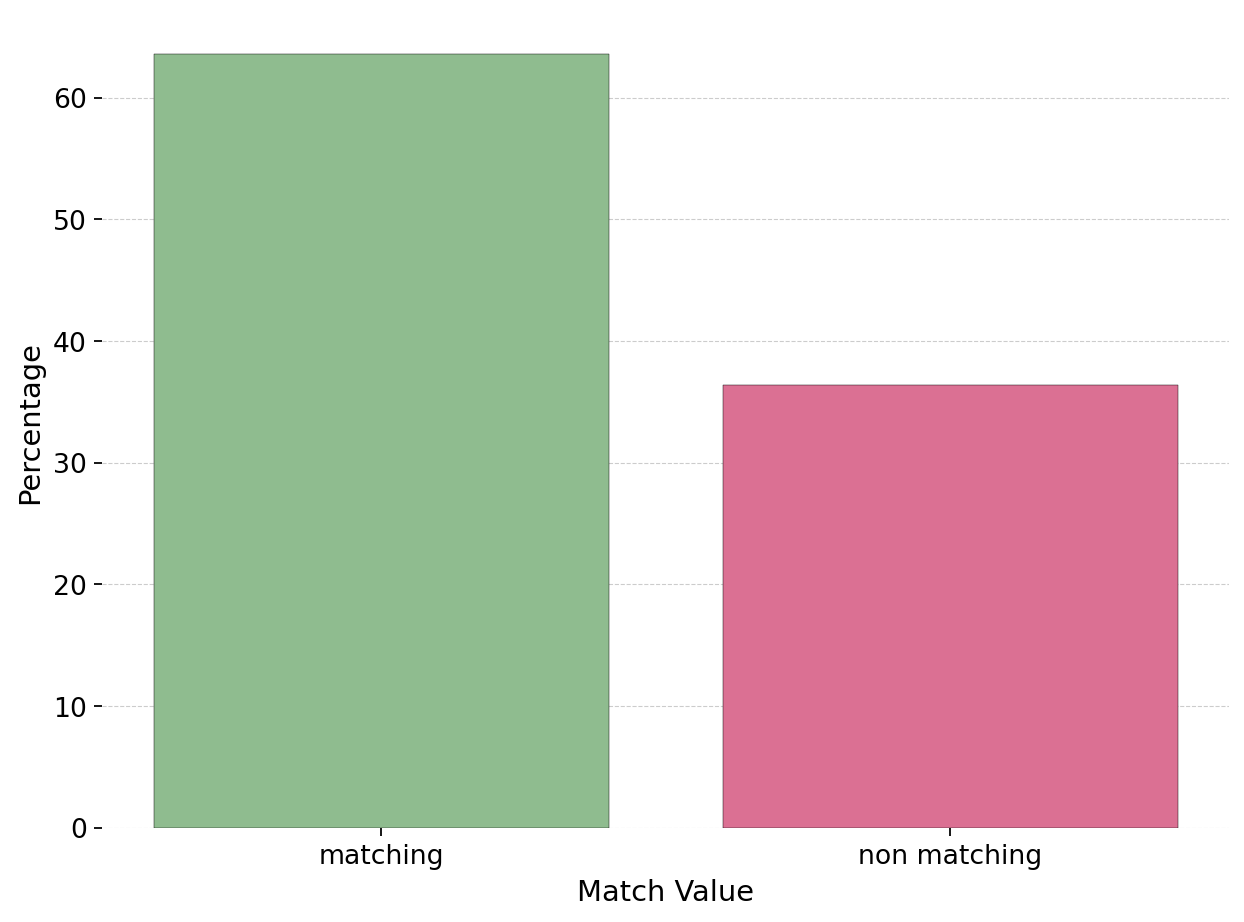

In [10]:
counts = rf_md['Match'].value_counts(normalize=True) * 100
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(counts.index.map({True: 'matching', False: 'non matching'}), counts.values, color=['darkseagreen', 'palevioletred'], edgecolor='black', linewidth=0.2)

ax.set_xlabel('Match Value', fontsize=13)
ax.set_ylabel('Percentage', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.yaxis.grid(True, linestyle='--', linewidth=0.5) 
ax.xaxis.grid(False)
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

# uncomment this to save high quality figure
#ax.savefig('matching_propotion.png', dpi=600, bbox_inches='tight')

## Figure 19

In [11]:
def remove_trailing_letter(sample):
    sample = re.sub(r'^([A-Za-z0-9]+)([A-Za-z])(_ATAC)$', r'\1\3', sample)
    sample = re.sub(r'^([A-Za-z0-9]+)([A-Za-z])(_nuclei)$', r'\1\3', sample)
    sample = re.sub(r'^([A-Za-z0-9]+)([A-Za-z])$', r'\1', sample)
    return sample
rf_md['stackedSamples'] = rf_md['Sample'].apply(remove_trailing_letter)

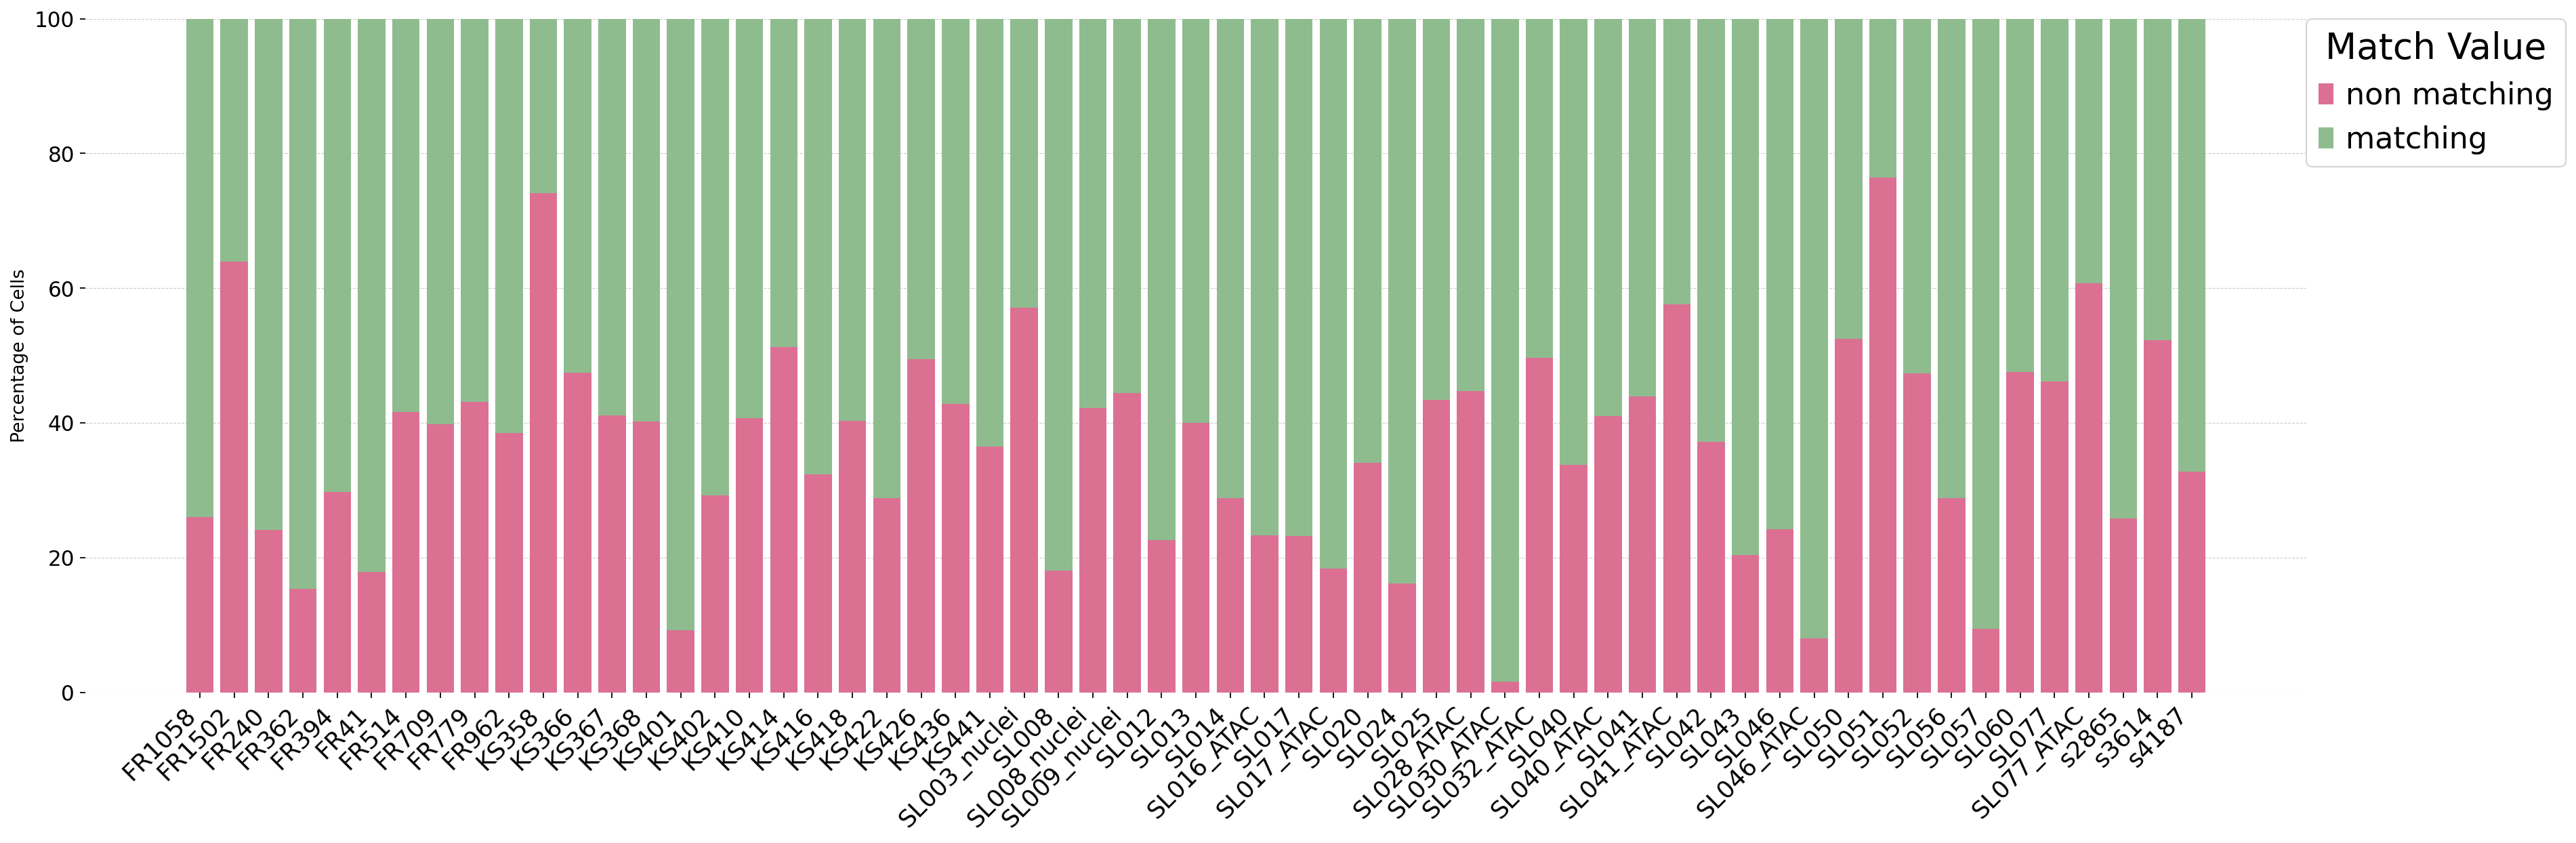

In [12]:
grouped = rf_md.groupby(['stackedSamples', 'Match']).size().unstack(fill_value=0)

percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(24, 8))  

added_labels = set()

labels_dict = {True: 'matching', False: 'non matching'}
colors = {'matching': 'darkseagreen', 'non matching': 'palevioletred'}

for idx, (sample, row) in enumerate(percentages.iterrows()):
    bottom = 0
    for match_value, pct in row.items():
        label = labels_dict[match_value]
        if label not in added_labels:
            ax.bar(idx, pct, bottom=bottom, label=label, color=colors[label])
            added_labels.add(label)
        else:
            ax.bar(idx, pct, bottom=bottom, color=colors[label])
        bottom += pct

ax.set_ylabel('Percentage of Cells', fontsize=12)
ax.set_xticks(range(len(percentages)))
ax.set_xticklabels(percentages.index, rotation=45, ha='right', fontsize=16)
ax.yaxis.grid(True, linestyle='--', linewidth=0.5) 
ax.xaxis.grid(False)
ax.set_axisbelow(True)
ax.set_ylim([0, 100])

legend = ax.legend(title='Match Value', title_fontsize='24', fontsize='20', bbox_to_anchor=(1, 1), loc='best', borderaxespad=0.)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

# uncomment this to save high quality figure
#ax.savefig('fig_19.png', dpi=600, bbox_inches='tight')

#### Some statistics class-by-class
- **confusion matrix**
- **per-class matching proportions**

In [14]:
# Compute the confusion matrix
confusion_matrix = pd.crosstab(rf_md['predictions_MD'], rf_md['predictions_RF'], 
                               rownames=['predictions_MD'], colnames=['predictions_RF'])

print("Confusion Matrix:")
print(confusion_matrix)

# Calculate per-class matching proportions from Predictions_M perspective
classes = set(rf_md['predictions_MD']).union(set(rf_md['predictions_RF']))

print("\nPer-class matching proportions (predictions_MD as reference):")
for cls in classes:
    subset = rf_md[rf_md['predictions_MD'] == cls]
    matches = (subset['predictions_MD'] == subset['predictions_RF']).sum()
    total = len(subset)
    proportion = matches / total if total > 0 else 0
    print(f"Class '{cls}': {proportion:.2%} matching")

# Calculate per-class matching proportions from Predictions_R perspective
print("\nPer-class matching proportions (Predictions_R as reference):")
for cls in classes:
    subset = rf_md[rf_md['predictions_RF'] == cls]
    matches = (subset['predictions_MD'] == subset['predictions_RF']).sum()
    total = len(subset)
    proportion = matches / total if total > 0 else 0
    print(f"Class '{cls}': {proportion:.2%} matching")

Confusion Matrix:
predictions_RF     Astrocytes   OPCs  Subcortical nIPCs  early Radial Glia  \
predictions_MD                                                               
Astrocytes             138387   6025               1496               8770   
OPCs                     3940  34008               2392                514   
Subcortical nIPCs         203    223               4515                 86   
early Radial Glia           2      0                  1                  1   
late Radial Glia           40      0                 10                104   
nIPCs                       7      1                145                  5   
pre-Astrocytes           5727   4112                 43                184   
pre-OPCs                  886   7258                953                211   

predictions_RF     late Radial Glia  nIPCs  pre-Astrocytes  pre-OPCs  
predictions_MD                                                        
Astrocytes                    19645    170           28253 

## Specific results (Sample SL040)

#### Percentage of matching predictions

In [18]:
test.obs = test.obs.join(rf_md[['predictions_RF', 'predictions_MD']], how='left')

In [19]:
test.obs['Match'] = test.obs['predictions_MD'] == test.obs['predictions_RF']
print("Proportion of equal predictions:", test.obs['Match'].mean())

Proportion of equal predictions: 0.6296266266672071


## Figure 18

#### PANEL A

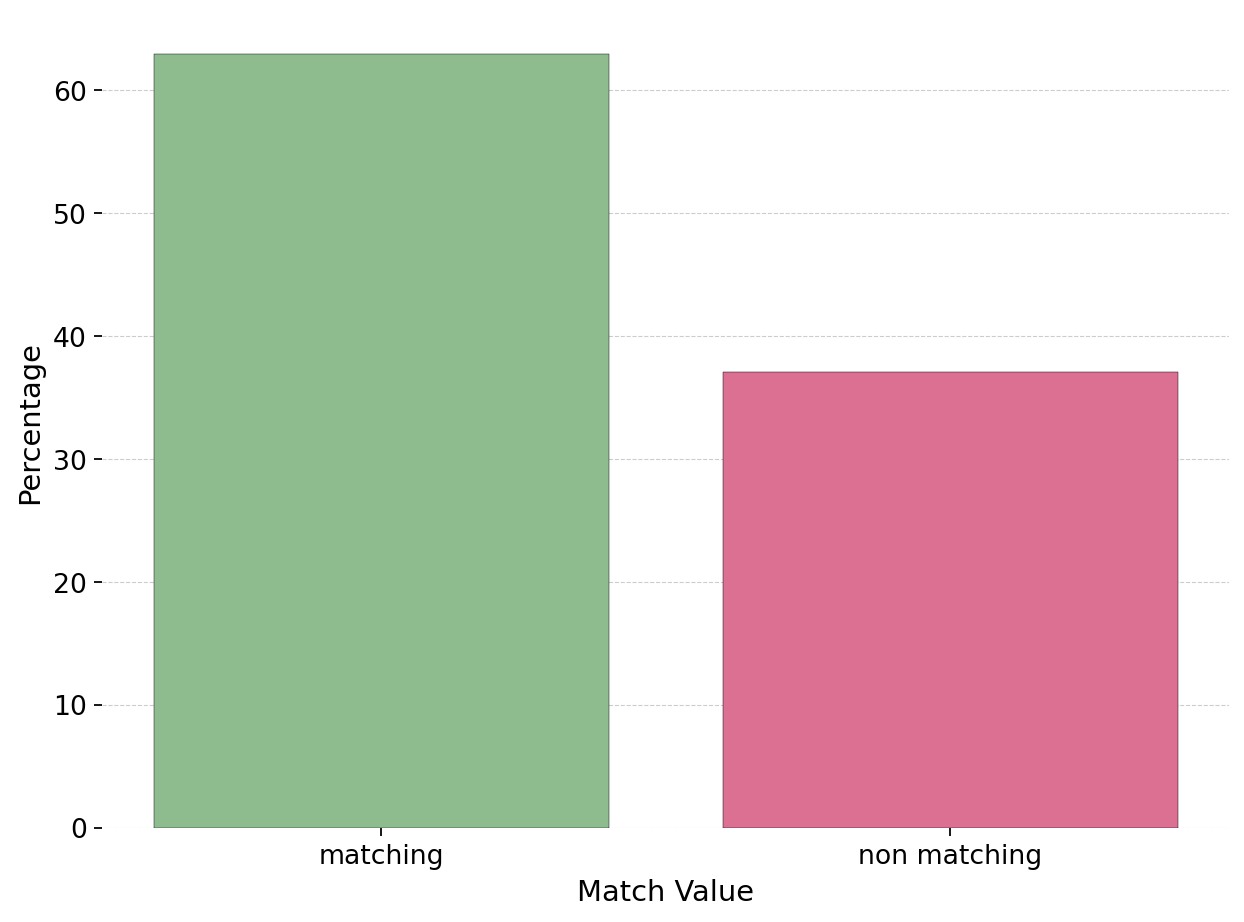

In [20]:
counts = test.obs['Match'].value_counts(normalize=True) * 100
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(counts.index.map({True: 'matching', False: 'non matching'}), counts.values, color=['darkseagreen', 'palevioletred'], edgecolor='black', linewidth=0.2)

ax.set_xlabel('Match Value', fontsize=13)
ax.set_ylabel('Percentage', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.yaxis.grid(True, linestyle='--', linewidth=0.5) 
ax.xaxis.grid(False)
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

# uncomment this to save high quality figure
#ax.savefig('fig_18_panel_A.png', dpi=600, bbox_inches='tight')

In [21]:
sc.set_figure_params(facecolor="white", figsize=(10, 4))

#### PANEL B

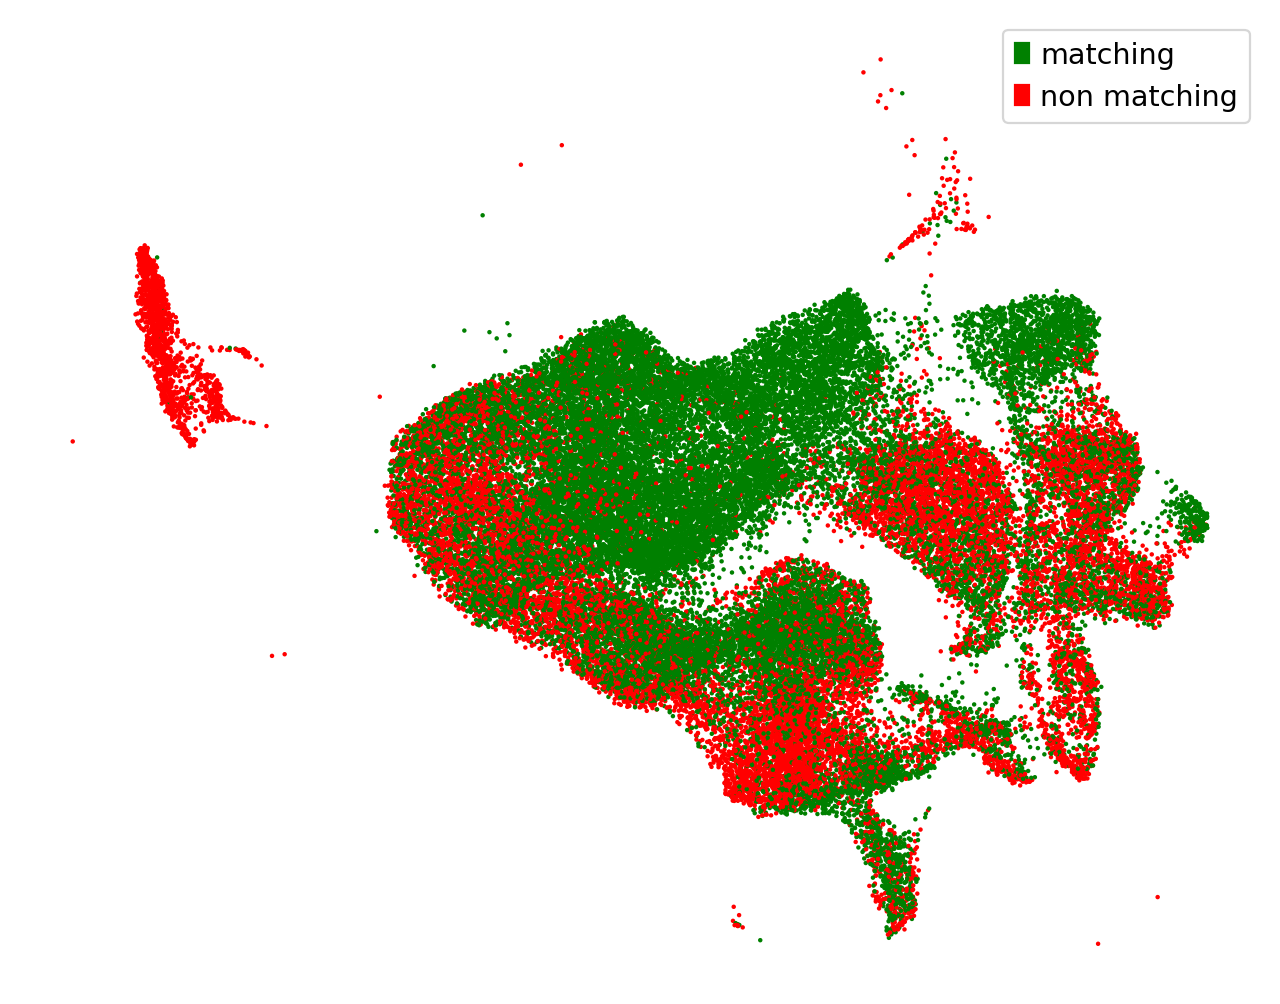

In [22]:
test.obs['Match'] =  test.obs['predictions_MD'] ==  test.obs['predictions_RF']
match_colors = test.obs['Match'].map({True: 'green', False: 'red'})

plt.figure(figsize=(10, 8))
plt.scatter(
    test.obsm['X_umap'][:, 0],
    test.obsm['X_umap'][:, 1],
    c=match_colors,
    s=1
)
agree_patch = mpatches.Patch(color='green', label='matching')
disagree_patch = mpatches.Patch(color='red', label='non matching')
plt.legend(handles=[agree_patch, disagree_patch], loc='best')
plt.axis('off')
plt.show()

# uncomment this to save high quality figure
#ax.savefig('fig_18_panel_B.png', dpi=600, bbox_inches='tight')